<a href="https://colab.research.google.com/github/Totti00/VA_Project/blob/main/sVitale_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/scl/fi/ybx2y1kvy99e2240gc9gg/san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn&dl=0
!unzip -q san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn
!rm san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install uvicorn
!pip install python-multipart
!pip install kaleido
!pip install fastapi
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
!pip install hausdorff

In [86]:
import os
import numba
import math
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from enum import Enum
from google.colab import output

def crop_image(image):
  cropped_image = image[1000:, 1500:]
  cropped_image = cropped_image[:2400, :2600]
  return cropped_image

def find_start(img):
  for x, line in enumerate(img):
    for y, col in enumerate(line):
      if col == 255:
        return (x, y)

def manhattan_check_around(img, last, edge):
  # Check up, down, left, and right directions
  for i in range(-1, 2, 2):
      x = max(0, min(last[0] + i, img.shape[0] - 1))
      y = last[1]
      if img[x][y] == 255 and [x, y] not in edge.tolist():
          return [x, y]

  for j in range(-1, 2, 2):
      x = last[0]
      y = max(0, min(last[1] + j, img.shape[1] - 1))
      if img[x][y] == 255 and [x, y] not in edge.tolist():
          return [x, y]

  # Check diagonals
  for i in range(-1, 2, 2):
      for j in range(-1, 2, 2):
          x = max(0, min(last[0] + i, img.shape[0] - 1))
          y = max(0, min(last[1] + j, img.shape[1] - 1))
          if img[x][y] == 255 and [x, y] not in edge.tolist():
              return [x, y]

  return -1

def manhattan_drow_edge(img, start):
  edge = np.array([[start[0], start[1]]])
  last = manhattan_check_around(img, start, edge)
  edge = np.vstack((edge, [last[0], last[1]]))
  while last != start:
    last = manhattan_check_around(img, last, edge)
    if last == -1:
      last = manhattan_check_around(img, edge[-2], edge)
      if last == -1:
        return edge
    else:
      edge = np.vstack((edge, [last[0], last[1]]))
  return edge

def contours_simplifier(edge):
  class Status(Enum):
    FINISH = 0
    STRAIGHT = 1
    STAIRS = 2
    DIAGONAL = 3
  status = Status.STRAIGHT
  while status != Status.FINISH:
    to_del = []
    if status == Status.STRAIGHT:
      for i in range(len(edge) - 1):
        if (edge[i - 1][0] == edge[i][0] == edge[i + 1][0]) or (edge[i - 1][1] == edge[i][1] == edge[i + 1][1]):
          to_del.append(i)
      edge = np.delete(edge, to_del, 0)
      if len(to_del) == 0:
        status = status.STAIRS
    if status == Status.STAIRS:
      for i in range(len(edge) - 1):
        if abs(edge[i - 1][0] - edge[i + 1][0]) == 1 and abs(edge[i - 1][1] - edge[i + 1][1]) == 1: # il pixel prima ed il pixel dopo si toccano coi vertici
          to_del.append(i)
      edge = np.delete(edge, to_del, 0)
      if len(to_del) == 0:
        status = status.DIAGONAL
    if status == Status.DIAGONAL:
      for i in range(len(edge) - 1):
        if abs(edge[i - 1][0] - edge[i + 1][0]) == abs(edge[i - 1][1] - edge[i + 1][1]):
          to_del.append(i)
      edge = np.delete(edge, to_del, 0)
      if len(to_del) == 0:
        status = status.FINISH
  return edge

def find_corners_right(arr):
  corners = []
  length = len(arr)
  for idx, point in enumerate(arr):
    angle = get_angle(arr[idx - 3], point, arr[(idx + 3) % length])
    if angle % 180 < 145:
      corners.append(idx)
  distances = get_distances([arr[i] for i in corners])
  results = []
  for idx, val in enumerate(corners):
    if math.sqrt(distances[idx]) > 150 or math.sqrt(distances[(idx + 1)%len(corners)]) > 150:
      results.append(val)
  return results

def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def get_angle(a, b, c):
  cosine_angle = get_cosine_angle(a, b, c)
  angle = np.arccos(cosine_angle)

  return np.degrees(angle)

def get_cosine_angle(a, b, c):
  ba = a - b
  bc = c - b
  return round(np.dot(ba, bc) / (((np.linalg.norm(ba) * np.linalg.norm(bc)) + 0.000000001)), 10)

def get_quad_distance(A, B):
  return ((B[0] - A[0])**2) + ((B[1] - A[1])**2)

def get_distances(arr):
  results = []
  for i in range(len(arr)):
    results.append(get_quad_distance(arr[i], arr[i - 1]))
    #results.append(distance(arr[i], arr[i - 1]))
  return results

@numba.jit(nopython=True, fastmath=True)
def custom_dist(array_x, array_y):
    n = array_x.shape[0]
    ret = 0.
    for i in range(n):
        ret += (array_x[i]-array_y[i])**3 / (array_x[i]**2 + array_y[i]**2 + 0.1)
    return ret

@numba.jit(fastmath=True)
def point_inside_polygon(x, y, poly):
  n = len(poly)
  inside = False
  p1x, p1y = poly[0]
  for i in range(0, n + 1, 10):
    p2x, p2y = poly[i % n]
    if y > min(p1y, p2y):
      if y <= max(p1y, p2y):
        if x <= max(p1x, p2x):
          if p1y != p2y:
            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
          if p1x == p2x or x <= xinters:
            inside = not inside
    p1x, p1y = p2x, p2y
  return inside

@numba.jit(fastmath=True)
def final_check_inside_contours(edge_max, edge_min):

  c = 0
  for point in edge_min:
    result = point_inside_polygon(point[0], point[1], edge_max)
    if (result):
      c += 1
    else:
      c = 0

    if c > 30:
      return True
  return False

def final_attach_fragments(edgeMin, edgeMax, x, x_size, y, y_size):
  if (len(edgeMin) == 1):
    return float('inf')
  if (len(edgeMax) == 1):
    return float('inf')

  edge_min = edgeMin.copy()
  edge_max = edgeMax.copy()

  shift = edge_min[x:x_size][0] - edge_max[y:y_size][0]

  edge_max += shift

  angle_prova = get_angle(edge_min[x:x_size][-1], edge_min[x:x_size][0], edge_max[y:y_size][-1])
  edge_max = rotate(edge_max, edge_max[y:y_size][0], angle_prova)
  edge_max = np.ceil(edge_max).astype(int)

  while(get_cosine_angle(edge_min[x:x_size][-1], edge_min[x:x_size][0], edge_max[y:y_size][-1]) < 0.90):
    if get_cosine_angle(edge_min[x:x_size][-1], edge_min[x:x_size][0], edge_max[y:y_size][-1]) == 0:
      break

    angle_prova = get_angle(edge_min[x:x_size][-1], edge_min[x:x_size][0], edge_max[y:y_size][-1])
    edge_max = rotate(edge_max, edge_max[y:y_size][0], angle_prova)
    edge_max = np.ceil(edge_max).astype(int)

  if (final_check_inside_contours(edge_max, edge_min)):
    return True
  return False

def merge_by_idx_with_order(idx1, idx2, coords, contours):
  edge_1 = contours_simplifier(contours[idx1].copy())
  edge_2 = contours_simplifier(contours[idx2].copy())#[::-1]


  edge_min = min((edge_1, edge_2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge_1, edge_2), key=len)

  shift = edge_min[coords[0]:coords[1]][0] - edge_max[coords[2]:coords[3]][0]
  edge_max += shift

  angle_prova = get_angle(edge_min[coords[0]:coords[1]][-1], edge_min[coords[0]:coords[1]][0], edge_max[coords[2]:coords[3]][-1])
  edge_max = rotate(edge_max, edge_max[coords[2]:coords[3]][0], angle_prova)
  edge_max = np.ceil(edge_max).astype(int)

  while(get_cosine_angle(edge_min[coords[0]:coords[1]][-1], edge_min[coords[0]:coords[1]][0], edge_max[coords[2]:coords[3]][-1]) < 0.90):
    angle_prova = get_angle(edge_min[coords[0]:coords[1]][-1], edge_min[coords[0]:coords[1]][0], edge_max[coords[2]:coords[3]][-1])
    edge_max = rotate(edge_max, edge_max[coords[2]:coords[3]][0], angle_prova)
    edge_max = np.ceil(edge_max).astype(int)

  joined_coords = np.concatenate((edge_min, edge_max))
  joined_coords += 1000

  # Creazione di un'immagine RGB
  seg_edge = np.zeros((6016, 6016, 3), dtype=np.uint8)
  seg_edge[:] = (0, 0, 0)  # Imposta lo sfondo a nero

  # Disegna i bordi totali
  x_coords, y_coords = joined_coords[:, 0], joined_coords[:, 1]
  seg_edge[x_coords, y_coords] = (255, 255, 255)  # Imposta il colore bianco per i bordi totali

  # Coordinare il colore dei bordi
  x_coords_color_edge1, y_coords_color_edge1 = joined_coords[coords[0]:coords[1], 0], joined_coords[coords[0]:coords[1], 1]
  x_coords_color_edge2, y_coords_color_edge2 = joined_coords[len(edge_min) + coords[2]:len(edge_min) + coords[3], 0], joined_coords[len(edge_min) + coords[2]:len(edge_min) + coords[3], 1]
  seg_edge[x_coords_color_edge1, y_coords_color_edge1] = (0, 0, 250)  # Imposta il colore del bordo comune
  seg_edge[x_coords_color_edge2, y_coords_color_edge2] = (0, 0, 250)  # Imposta il colore del bordo comune

  cv2_imshow(seg_edge)

def merge_by_idx_without_shared_edge(idx1, idx2, coords, contours):
  edge_1 = contours_simplifier(contours[idx1].copy())
  edge_2 = contours_simplifier(contours[idx2].copy())#[::-1]

  edge_min = min((edge_1, edge_2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge_1, edge_2), key=len)

  shift = edge_min[coords[0]:coords[1]][0] - edge_max[coords[2]:coords[3]][0]
  edge_max += shift

  angle_prova = get_angle(edge_min[coords[0]:coords[1]][-1], edge_min[coords[0]:coords[1]][0], edge_max[coords[2]:coords[3]][-1])
  edge_max = rotate(edge_max, edge_max[coords[2]:coords[3]][0], angle_prova)
  edge_max = np.ceil(edge_max).astype(int)

  while(get_cosine_angle(edge_min[coords[0]:coords[1]][-1], edge_min[coords[0]:coords[1]][0], edge_max[coords[2]:coords[3]][-1]) < 0.90):
    angle_prova = get_angle(edge_min[coords[0]:coords[1]][-1], edge_min[coords[0]:coords[1]][0], edge_max[coords[2]:coords[3]][-1])
    edge_max = rotate(edge_max, edge_max[coords[2]:coords[3]][0], angle_prova)
    edge_max = np.ceil(edge_max).astype(int)

  edg_max_part1_converted = np.concatenate([x for x in reversed(edge_max[:coords[2]])]).reshape(-1, 2)
  edg_max_part2_converted = np.concatenate([x for x in reversed(edge_max[coords[3]:])]).reshape(-1, 2)


  joined_coords_without_shared_edge = np.concatenate((edge_min[coords[1]:], edge_min[:coords[0]], edg_max_part1_converted, edg_max_part2_converted))
  joined_coords_without_shared_edge = joined_coords_without_shared_edge[::-1]
  joined_coords_without_shared_edge += 1000


  seg_edge = np.zeros((6016, 6016))
  x_coords, y_coords = joined_coords_without_shared_edge[:, 0], joined_coords_without_shared_edge[:, 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)

  return joined_coords_without_shared_edge

# Questo codice qui sotto controlla tutta la directory 6 e per ogni immagine calcola SAM e canny.
## Questo produce anche un array (contours) che contiene tutti gli array  dei bordi di tutte le immagini

In [4]:
#Serve per inizializzare il tutto
HOME = os.getcwd()
print("HOME:", HOME)

!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=8)

HOME: /content
/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [87]:
folder_path = "/content/dataset/train/6"

# Elenco dei file nella cartella
file_list = os.listdir(folder_path)

#Array contenente gli array dei bordi di tutte le immagini
array_contours = []

# Apri tutte le immagini con OpenCV
images = []
for file_name in file_list:
  if file_name.endswith(('.png', '.jpg', '.jpeg')) and not file_name.startswith('gt') :
    nome_file = file_name.split('.')[0]
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path)
    img = crop_image(image)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sam_result = mask_generator.generate(image_rgb)
    masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]

    img = masks[1].astype('uint8') * 255 #serve per mapparla da booleano a scala di grigi
    blurred = cv2.GaussianBlur(img, (13, 13), 0)
    edges_D = cv2.Canny(blurred,0,100)
    prova = manhattan_drow_edge(edges_D, find_start(edges_D))
    array_contours.append(prova)
    seg_edge = np.zeros((4016, 6016))
    x_coords, y_coords = prova[:, 0], prova[:, 1]
    seg_edge[x_coords, y_coords] = 255

contours = [np.array(sublist) for sublist in array_contours]

In [88]:
def new_match_for_multi(arr1, arr2):
  edge1 = contours_simplifier(arr1.copy())
  edge2 = contours_simplifier(arr2.copy())

  edge_min = min((edge1, edge2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge1, edge2), key=len)

  min_distance = float('inf')
  min_coords = None

  corners_idx = edge_min[find_corners_right(edge_min)]

  corners_idx2 = edge_max[find_corners_right(edge_max)]

  for idx1, corner1 in enumerate(corners_idx[:-1]):
    for idx1_0 in range(idx1+1, len(corners_idx)):
      corner1_0 = corners_idx[idx1_0]
      length1 = math.sqrt((corner1_0[0] - corner1[0])**2 + (corner1_0[1] - corner1[1])**2)

      if length1 > 600:

        for idx2, corner2 in enumerate(corners_idx2[:-1]):
          for idx2_0 in range(idx2+1, len(corners_idx2)):
            corner2_0 = corners_idx2[idx2_0]
            length2 = math.sqrt((corner2_0[0] - corner2[0])**2 + (corner2_0[1]- corner2[1])**2)

            distance_lungh = abs(length1 - length2) / max(length1, length2)

            if length2 > 600:
              x = np.where((edge_min[:, 0] == corner1[0]) & (edge_min[:, 1] == corner1[1]))[0][0]
              x_size = np.where((edge_min[:, 0] == corner1_0[0]) & (edge_min[:, 1] == corner1_0[1]))[0][0]
              y = np.where((edge_max[:, 0] == corner2[0]) & (edge_max[:, 1] == corner2[1]))[0][0]
              y_size = np.where((edge_max[:, 0] == corner2_0[0]) & (edge_max[:, 1] == corner2_0[1]))[0][0]

              if distance_lungh < min_distance:
                if ((not final_attach_fragments(edge_min, edge_max, x, x_size, y, y_size))):
                  #print(eval_match(edge_max[y:y_size], edge_min[x:x_size]))
                  min_distance = distance_lungh
                  min_coords = (x, x_size, y, y_size)

  return min_distance, min_coords

0 1
0.022304299761391182
0 2
0.30412086282367784
1 2
0.036158400192149984
best_score:  0.022304299761391182
(48, 412, 440, 751)
0 1


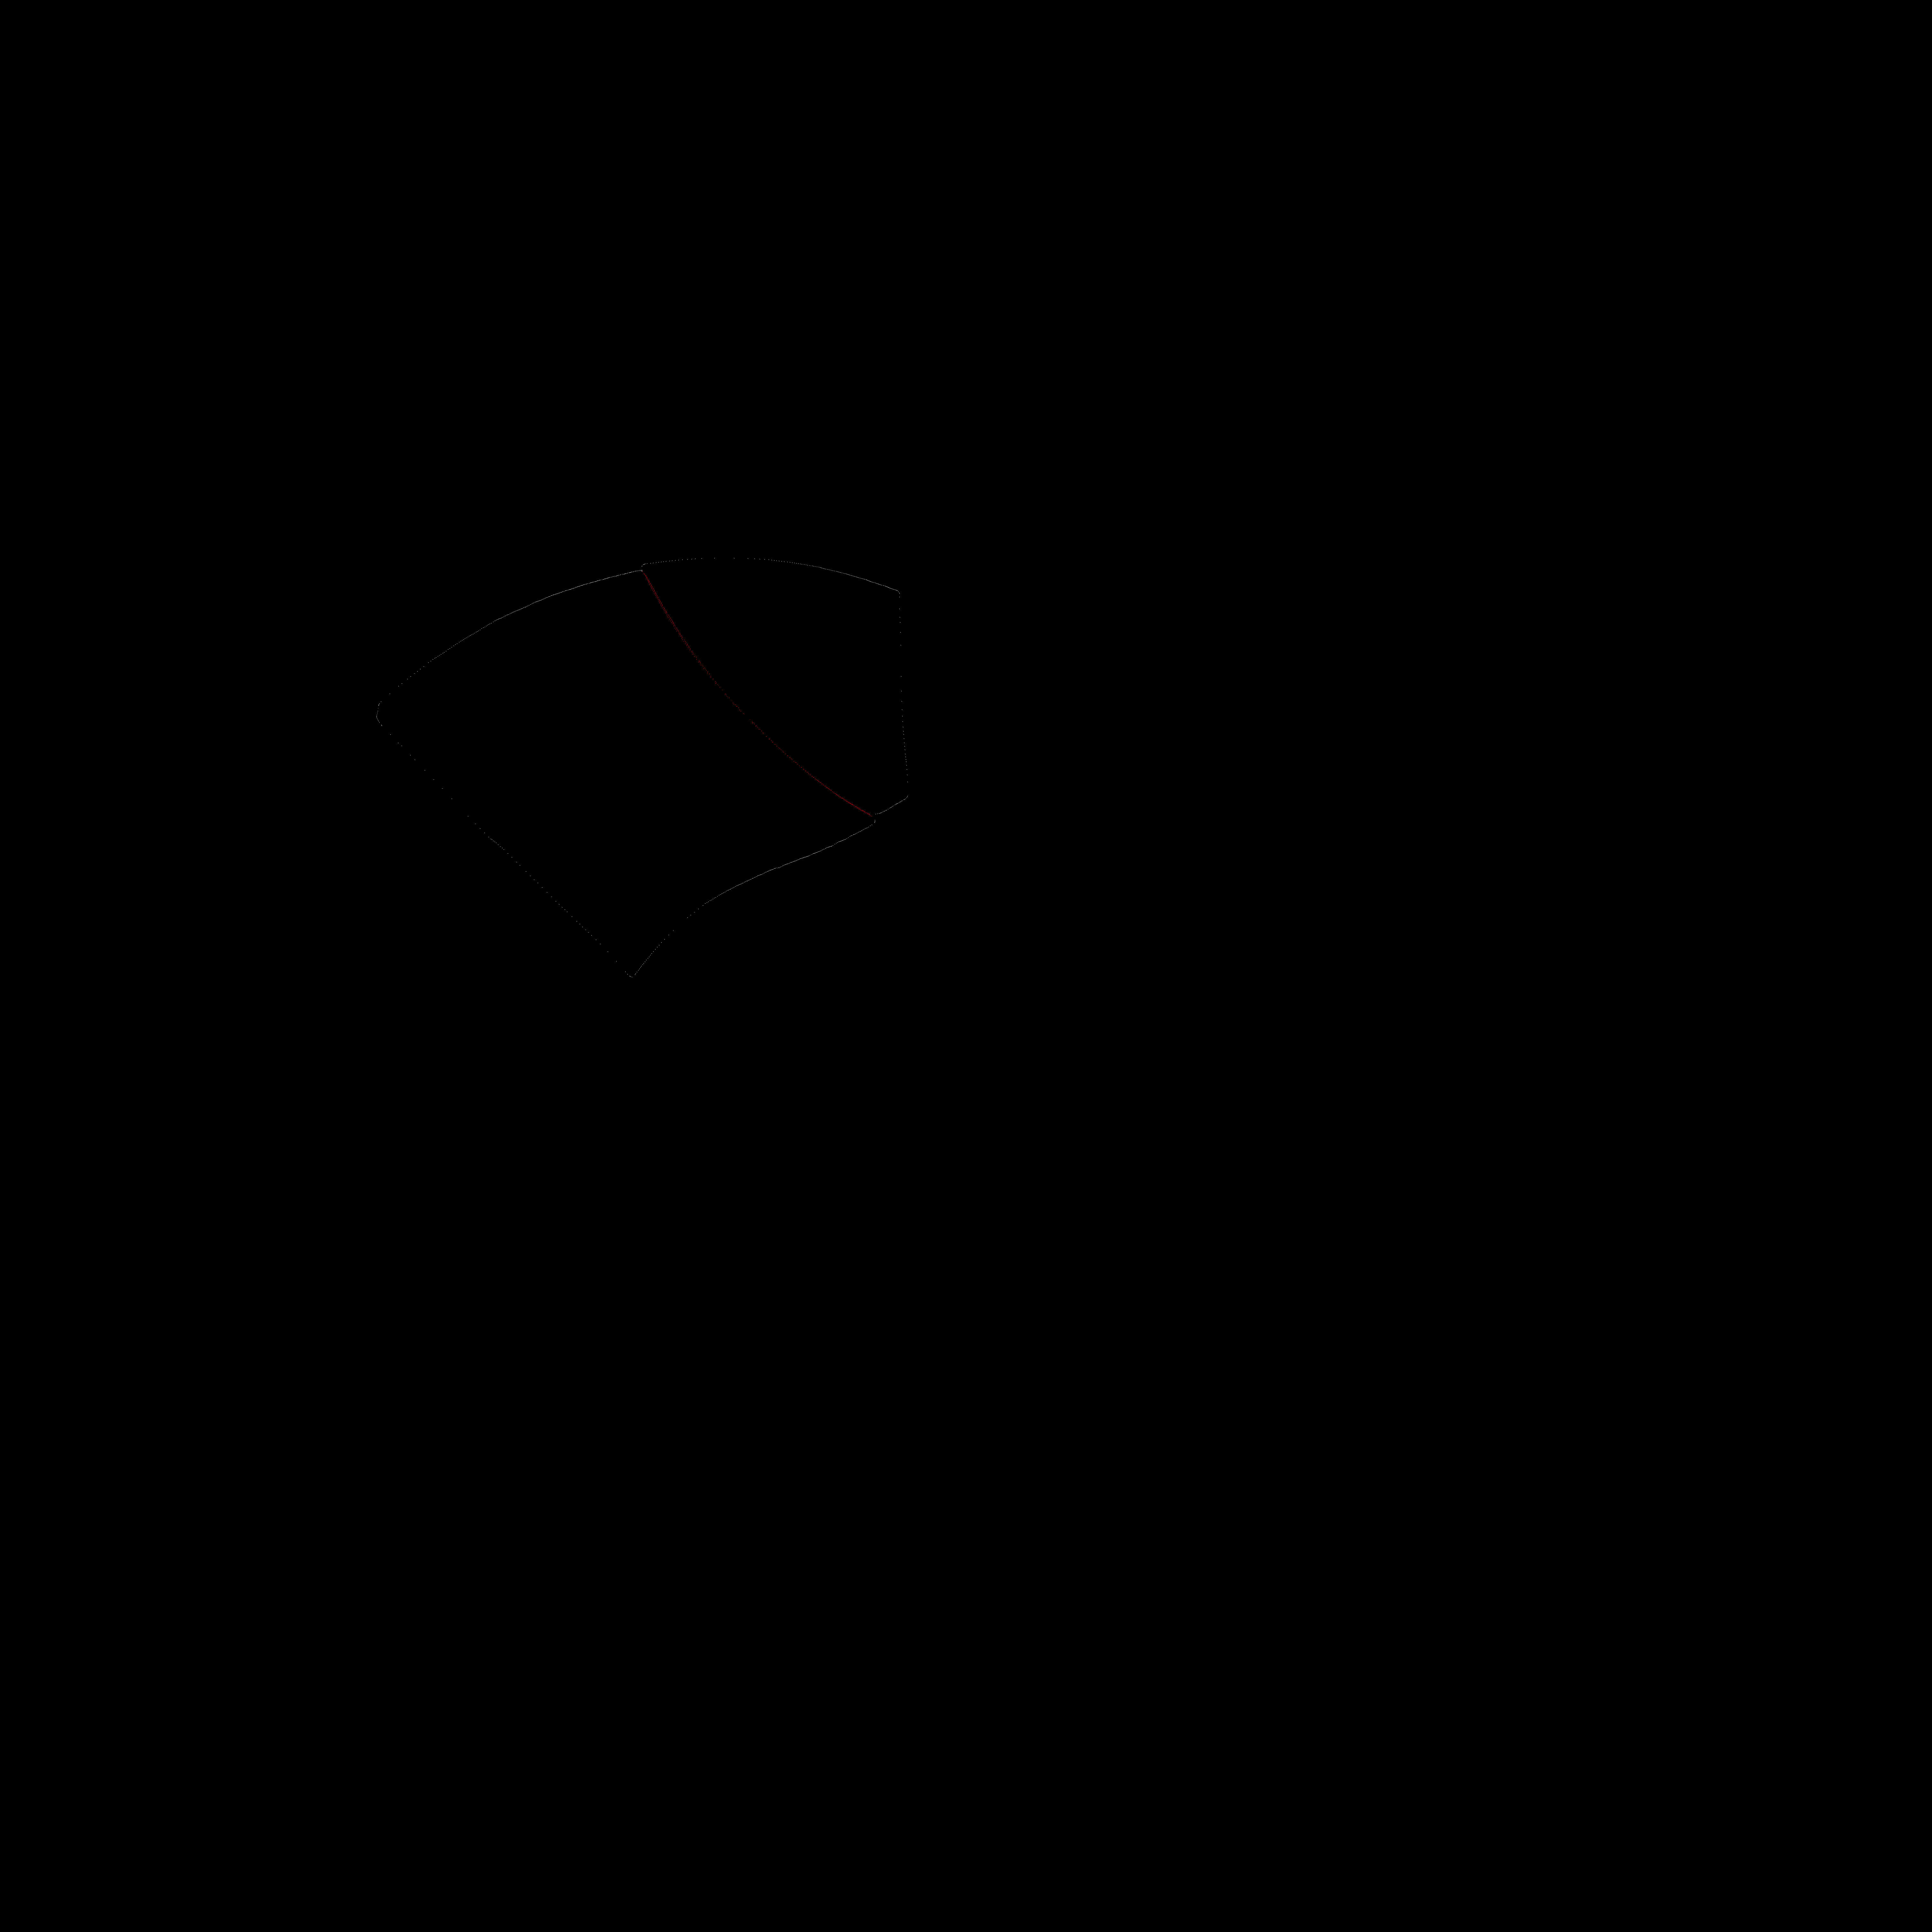

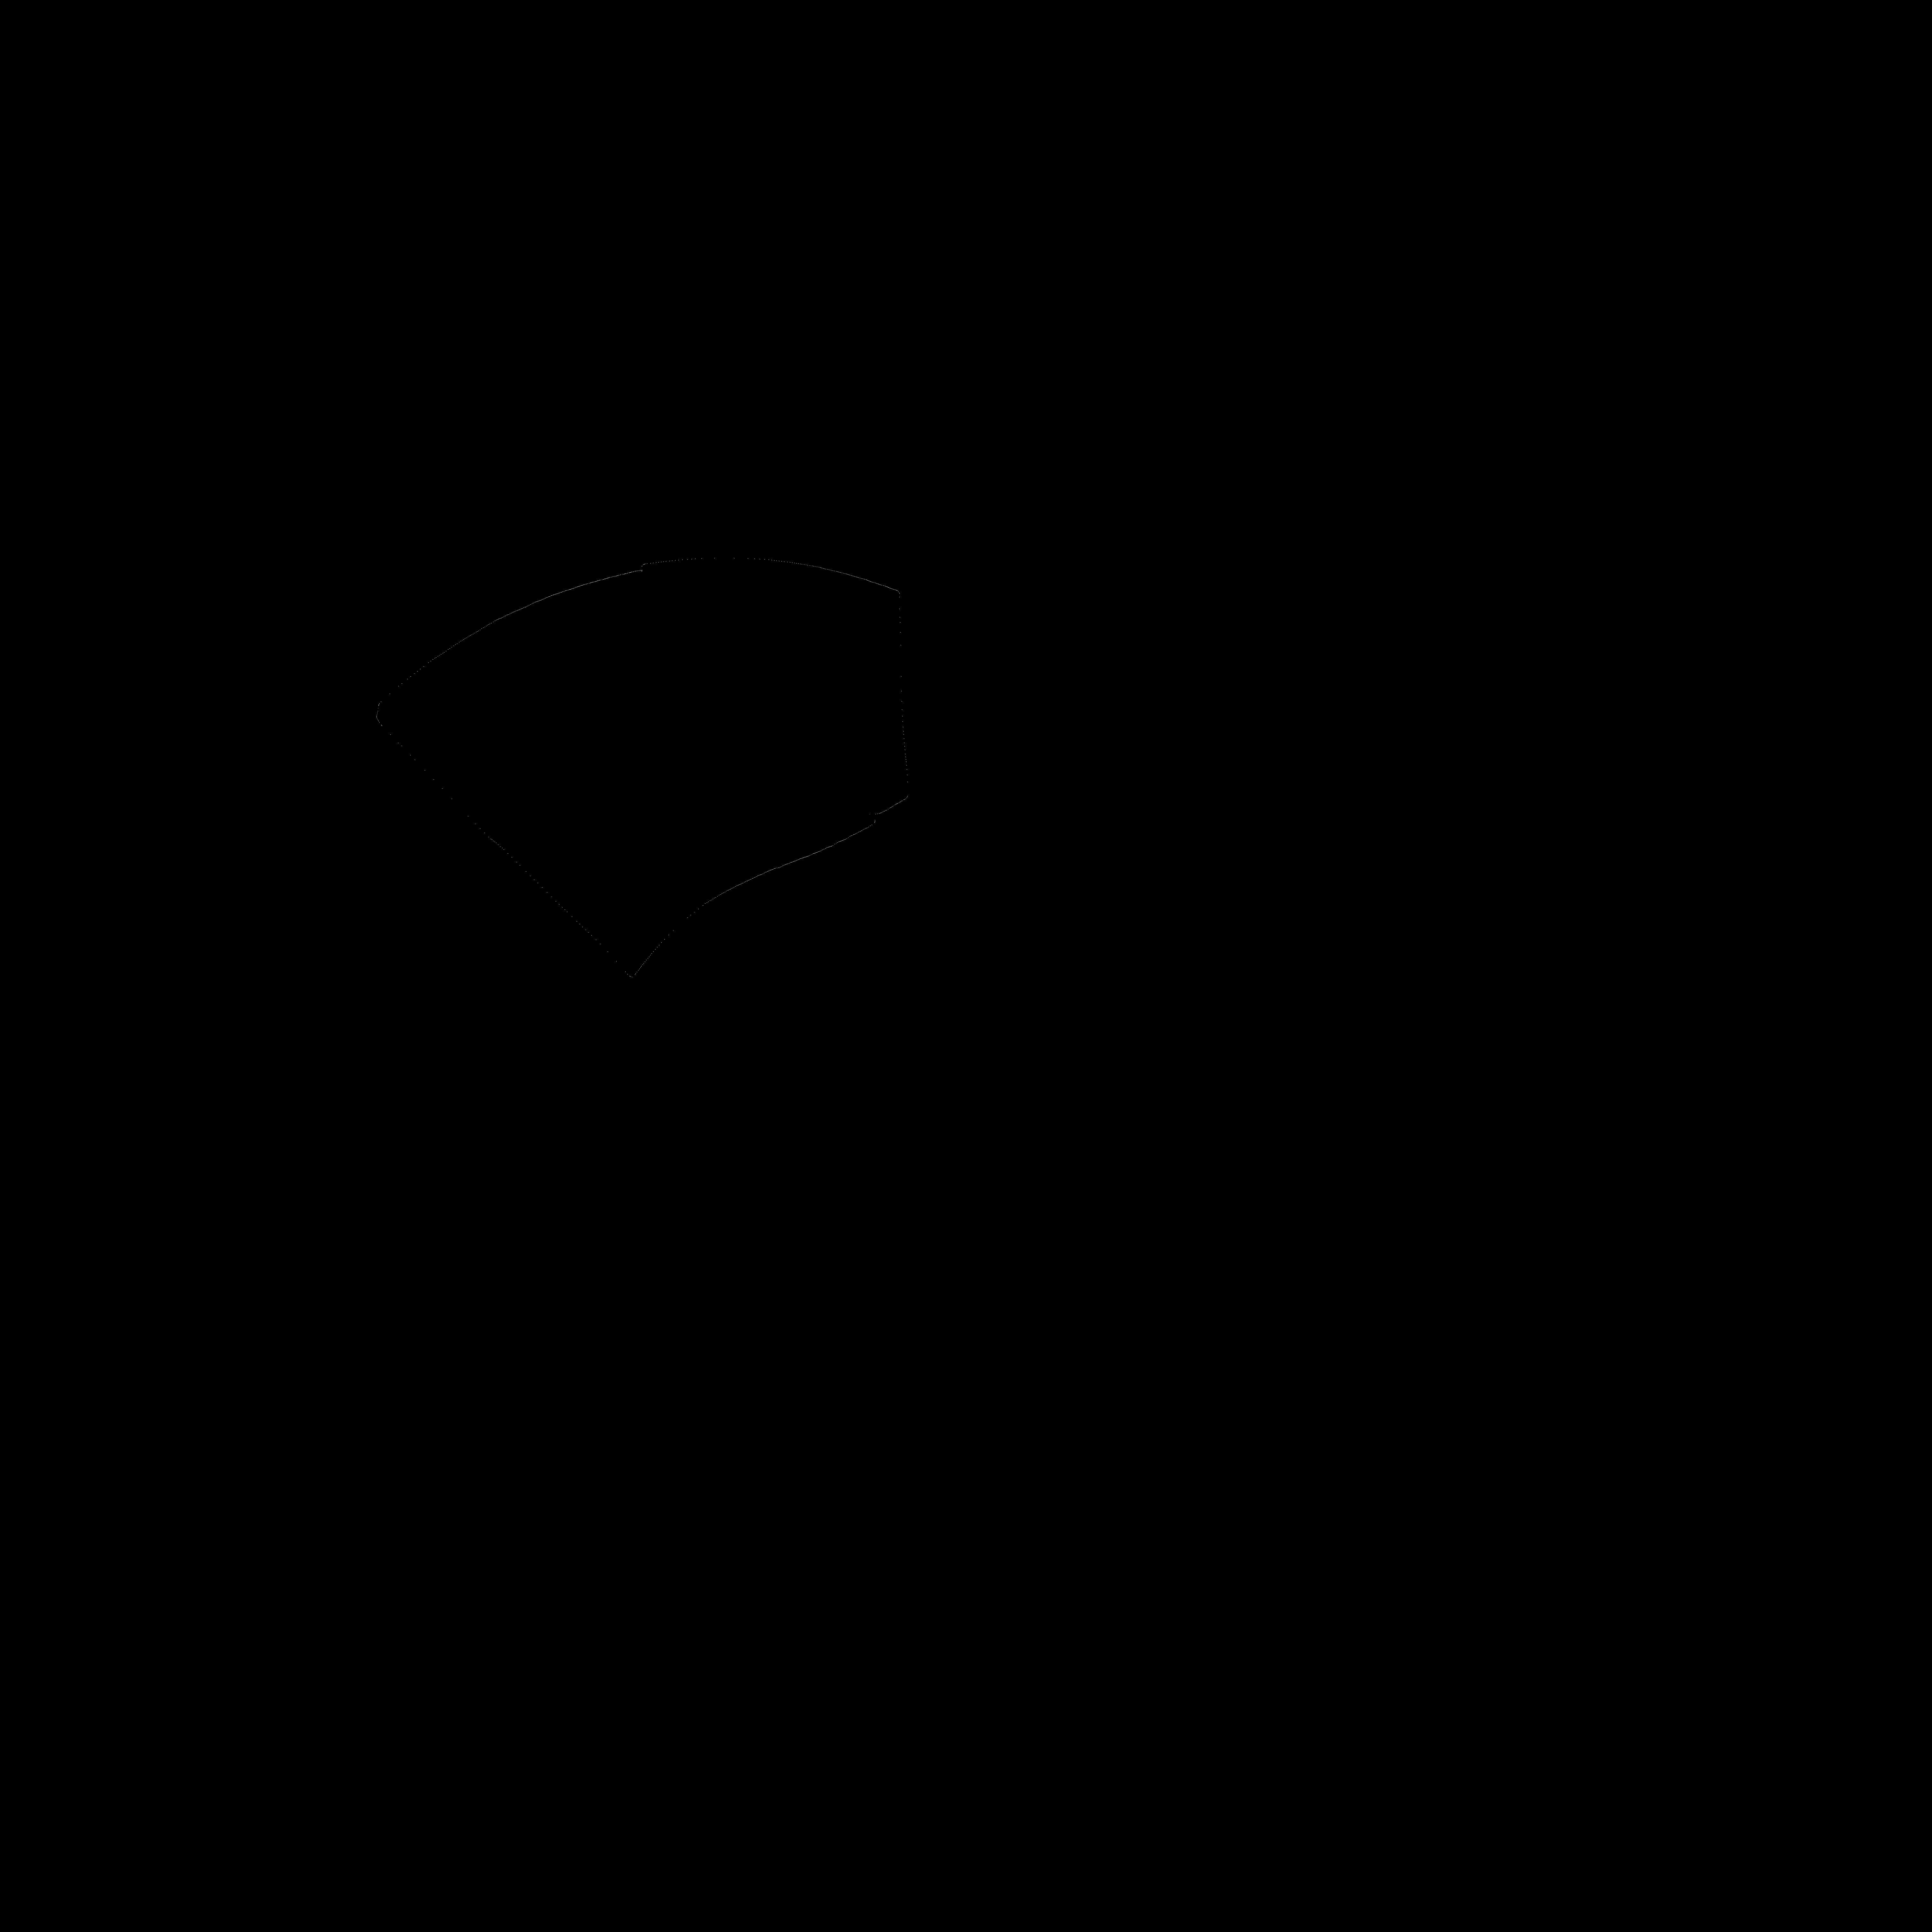

0 1
0.036158400192149984
best_score:  0.036158400192149984
(23, 347, 1106, 1161)
0 1


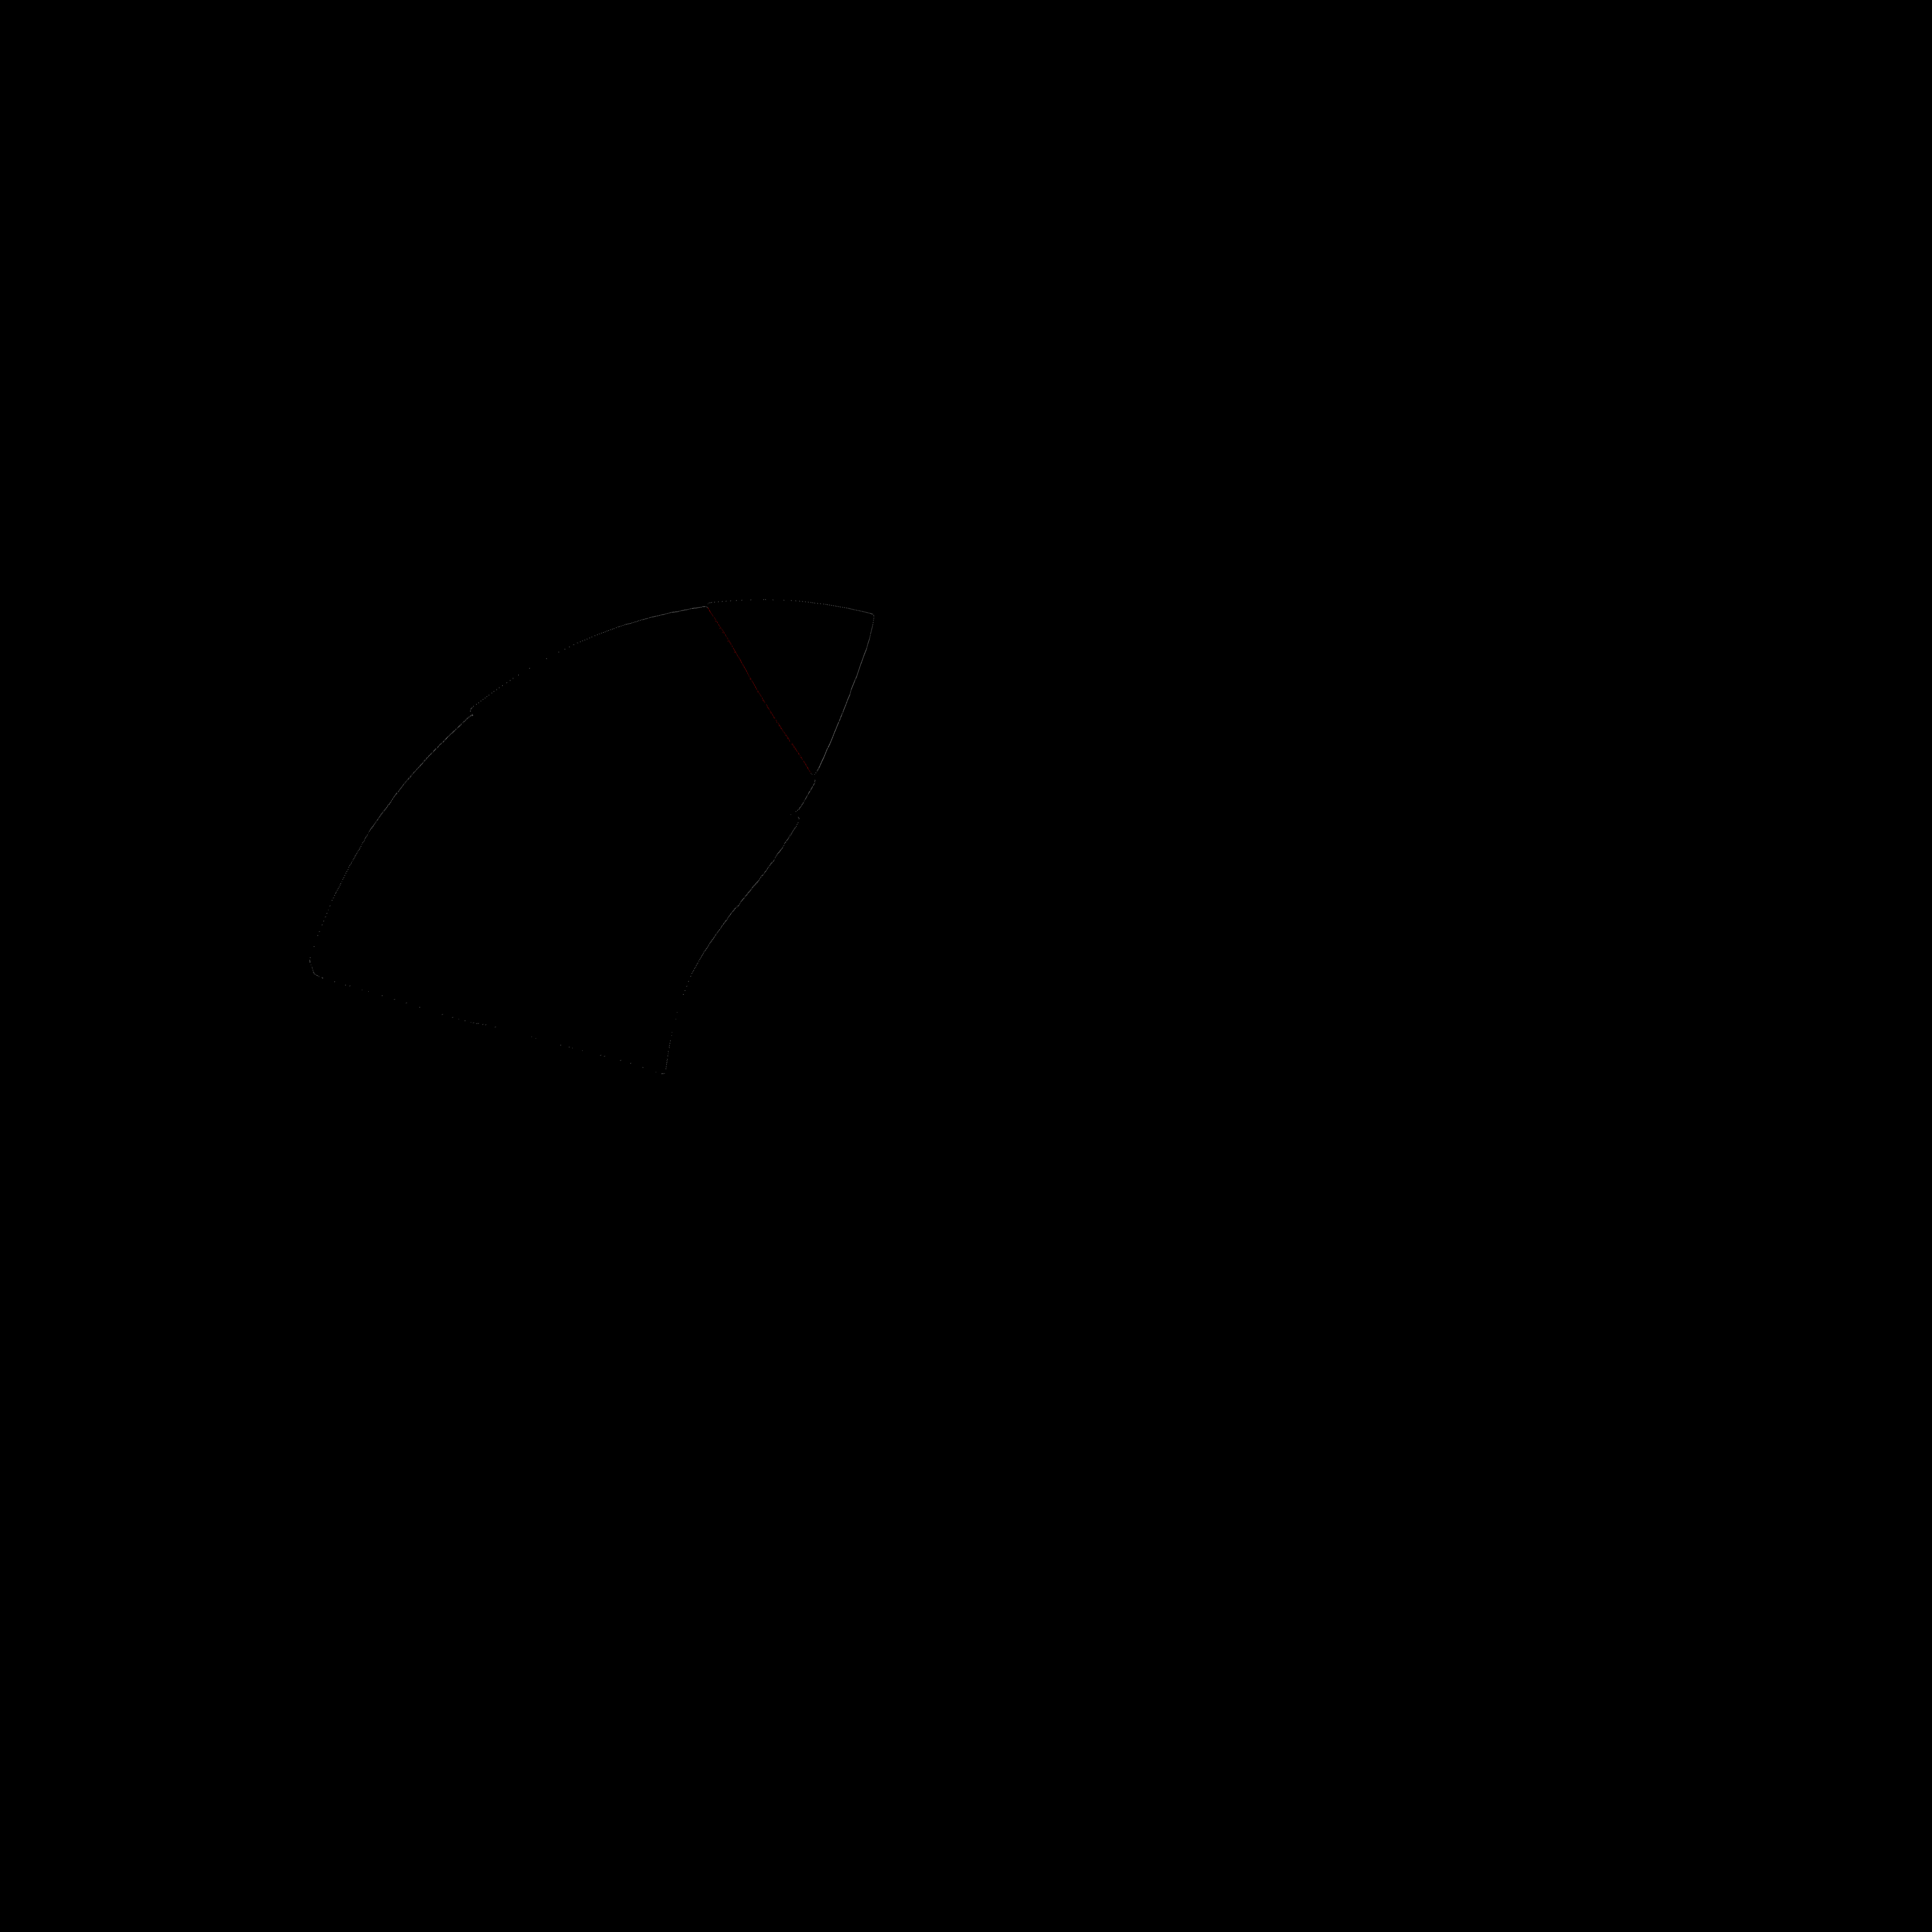

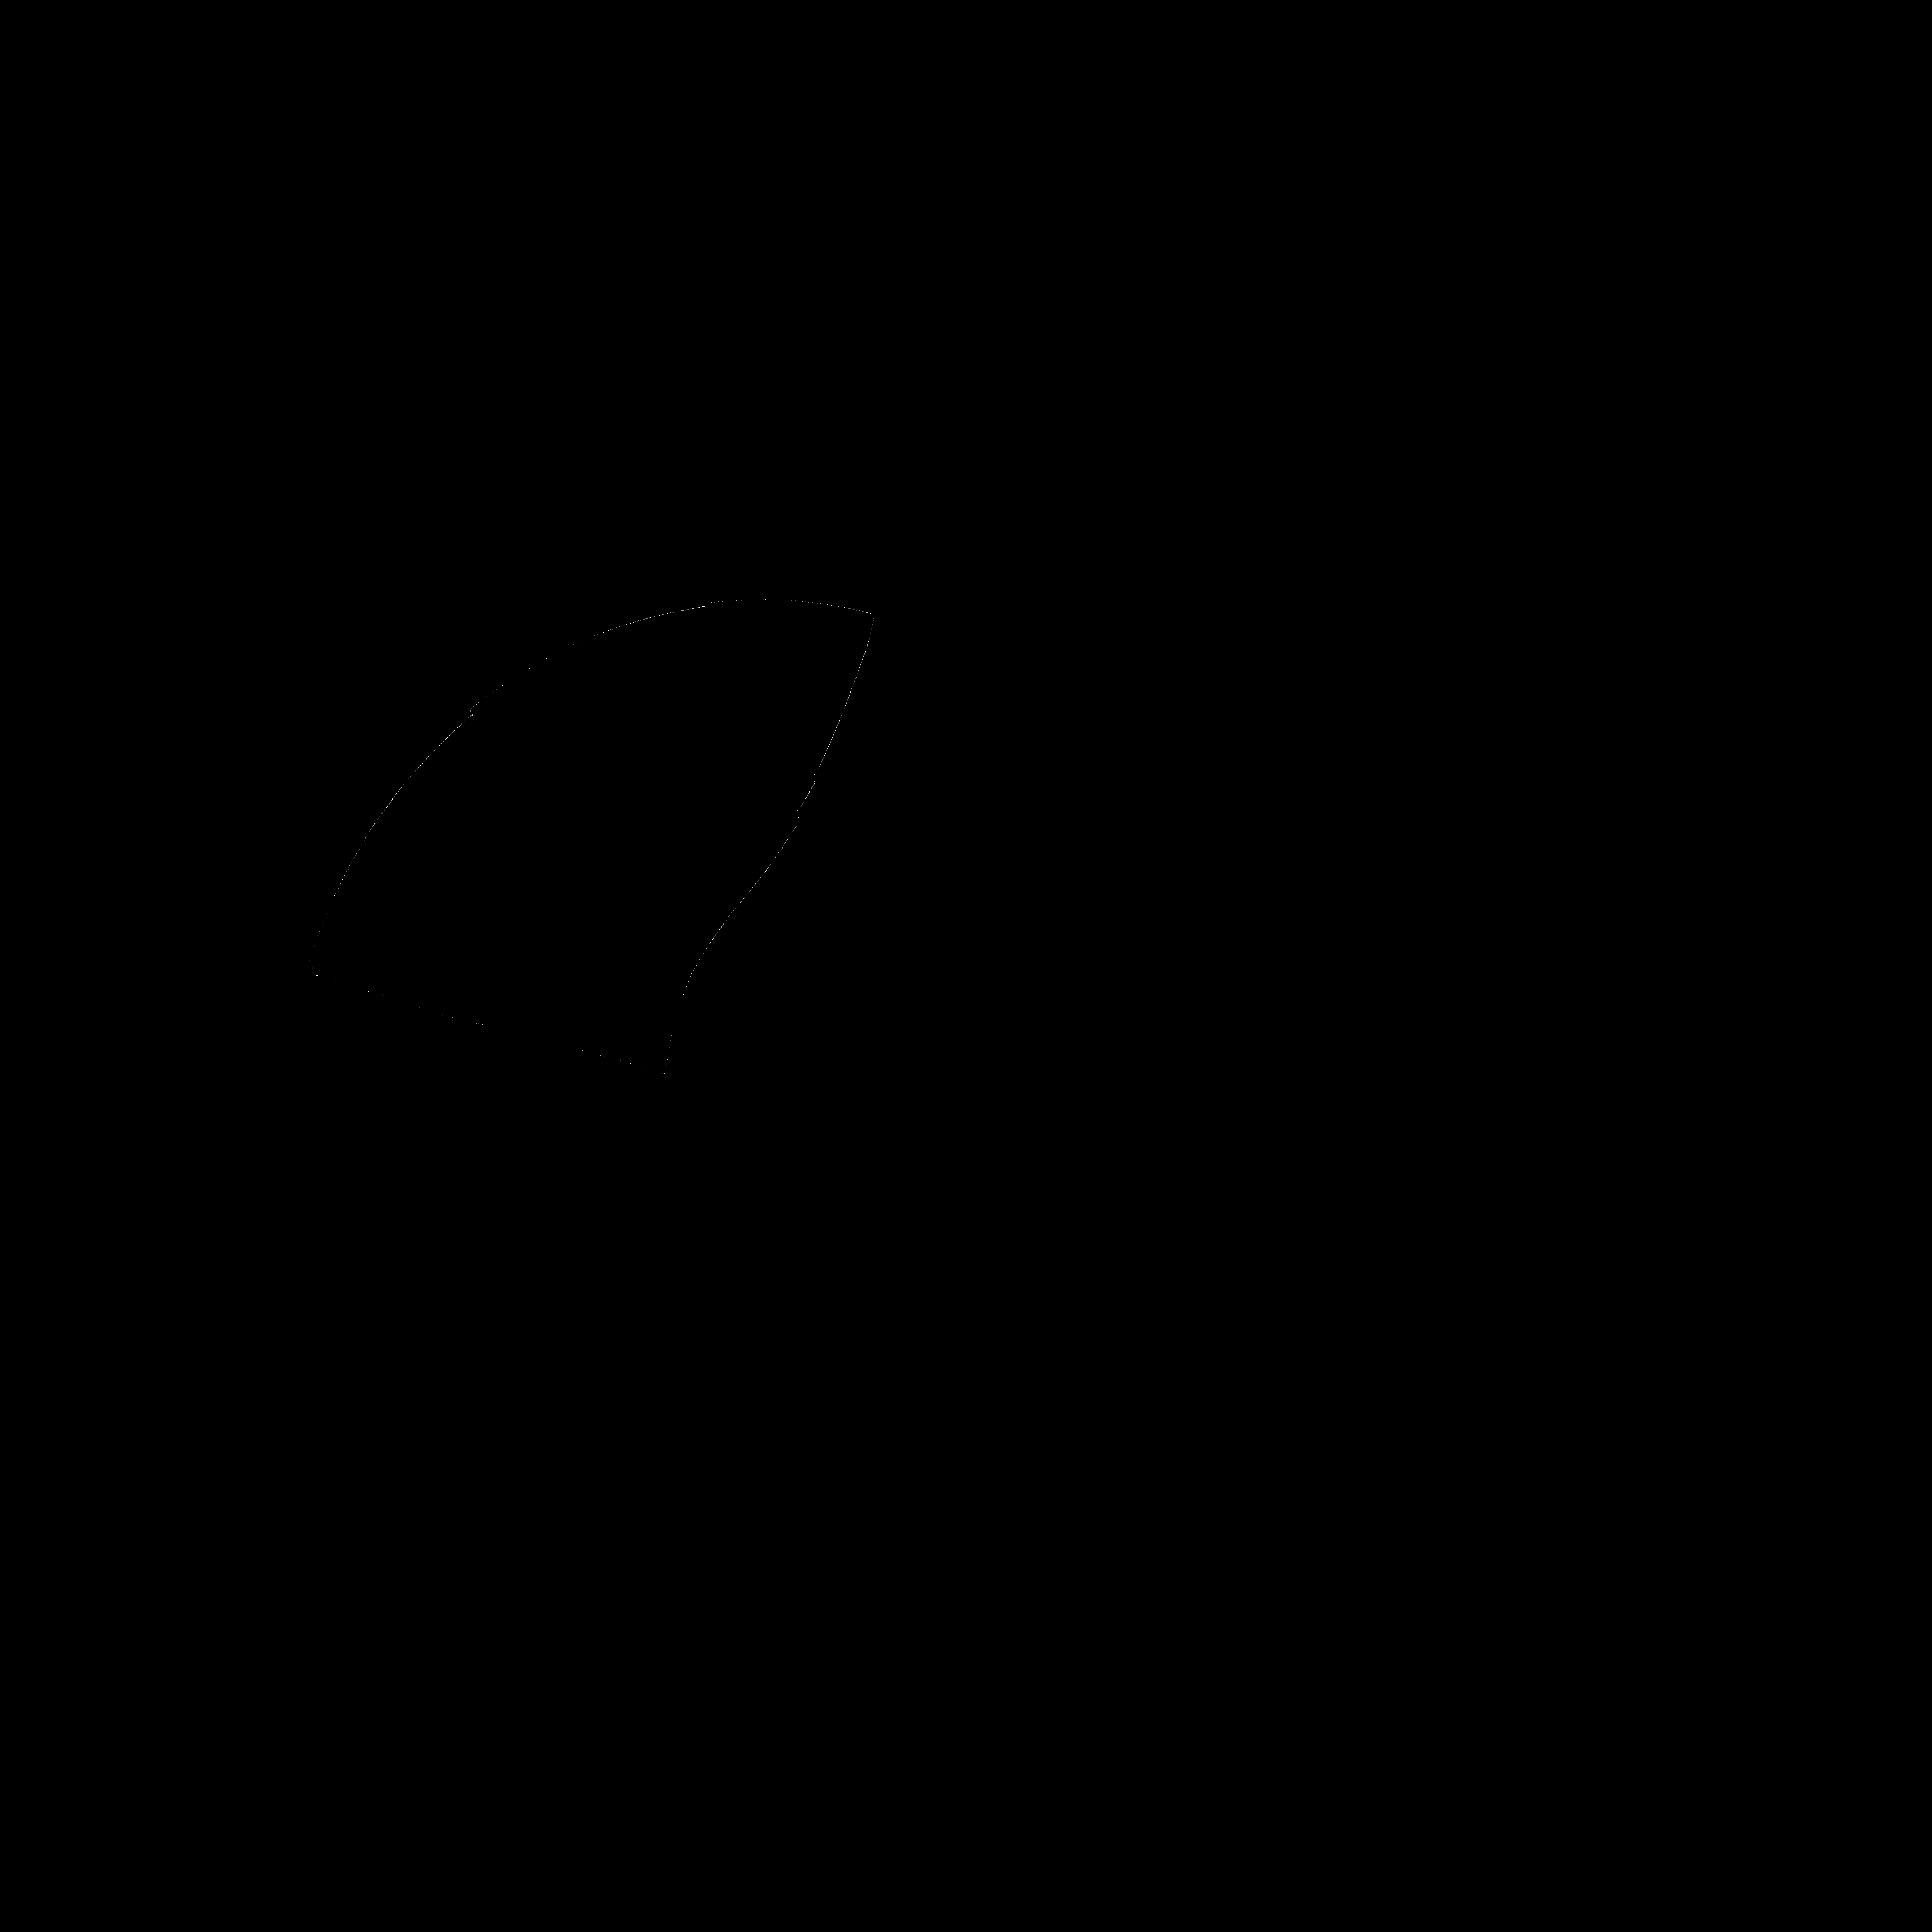

In [89]:
def test_multiple_match(contours):
  if len(contours) == 1:
    return contours[0]
  best_score = float('inf')
  bestX, bestY = -1, -1
  for x in range(0, len(contours)-1):
    for y in range(x + 1, len(contours)):
      print(x, y)
      score, coords = new_match_for_multi(contours[x], contours[y])
      print(score)
      if score < best_score:
        best_score = score
        min_coords = coords
        bestX = x
        bestY = y

  print("best_score: ", best_score)
  print(min_coords)
  print(bestX, bestY)
  merge_by_idx_with_order(bestX, bestY, min_coords, contours)
  array = merge_by_idx_without_shared_edge(bestX, bestY, min_coords, contours)
  del contours[bestY]
  del contours[bestX]
  contours.append(array)
  return test_multiple_match(contours)

img = test_multiple_match(sorted(contours, key=len, reverse=True)[1:])